# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=350  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=512, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


     


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), (1024,1)]
    #cfg = [48, (96,2), 96, (192,2), 192, (384,2), 384, 384, 384, 384, 384, (768,2), (1024,1)]
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512,1024,1024]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        #print("X",out.shape)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1=open("Cifar10_INFO.txt","a+")
            f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    f1.close()

In [ ]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [ ]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=80 and (epoch-80)%10==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.316633, Accuracy: 6.05
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.334813, Accuracy: 10.94
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.103926, Accuracy: 19.73
Train Epoch: 0 [7680/50000 (17%)]	Loss: 1.987253, Accuracy: 28.12
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.003929, Accuracy: 24.61
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.877870, Accuracy: 31.45
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.871561, Accuracy: 29.10
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.734167, Accuracy: 33.01
Train Epoch: 0 [20480/50000 (45%)]	Loss: 1.763204, Accuracy: 30.08
Train Epoch: 0 [23040/50000 (51%)]	Loss: 1.738399, Accuracy: 39.26
Train Epoch: 0 [25600/50000 (57%)]	Loss: 1.658604, Accuracy: 36.13
Train Epoch: 0 [28160/50000 (62%)]	Loss: 1.714431, Accuracy: 36.13
Train Epoch: 0 [30720/50000 (68%)]	Loss: 1.649105, Accuracy: 35.74
Train Epoch: 0 [33280/50000 (74%)]	Loss: 1.725535, Accuracy: 37.50
Train Epoch: 0 [35840/50000 (80%)]	Loss: 1.609963, Accuracy: 38.09
Train

Train Epoch: 6 [12800/50000 (28%)]	Loss: 0.806780, Accuracy: 73.24
Train Epoch: 6 [15360/50000 (34%)]	Loss: 0.723399, Accuracy: 74.61
Train Epoch: 6 [17920/50000 (40%)]	Loss: 0.664551, Accuracy: 78.12
Train Epoch: 6 [20480/50000 (45%)]	Loss: 0.730873, Accuracy: 74.80
Train Epoch: 6 [23040/50000 (51%)]	Loss: 0.682457, Accuracy: 76.37
Train Epoch: 6 [25600/50000 (57%)]	Loss: 0.707583, Accuracy: 76.37
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.799364, Accuracy: 71.48
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.709580, Accuracy: 75.39
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.716732, Accuracy: 74.02
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.661525, Accuracy: 75.59
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.662983, Accuracy: 77.54
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.718588, Accuracy: 76.56
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.722670, Accuracy: 75.59

Validation set: Average loss: 0.8823, Accuracy: 3545/5000 (70.00%)

the time of this epoch:[19.88586401939392 s]
Train Epoch: 7 

Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.520261, Accuracy: 80.47
Train Epoch: 12 [28160/50000 (62%)]	Loss: 0.560455, Accuracy: 80.86
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.633990, Accuracy: 78.71
Train Epoch: 12 [33280/50000 (74%)]	Loss: 0.633639, Accuracy: 77.34
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.560859, Accuracy: 81.05
Train Epoch: 12 [38400/50000 (85%)]	Loss: 0.504683, Accuracy: 80.86
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.553368, Accuracy: 82.23
Train Epoch: 12 [43520/50000 (97%)]	Loss: 0.573717, Accuracy: 79.88

Validation set: Average loss: 0.8011, Accuracy: 3646/5000 (72.00%)

the time of this epoch:[19.921853065490723 s]
Train Epoch: 13 [0/50000 (0%)]	Loss: 0.553655, Accuracy: 80.66
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.474742, Accuracy: 83.01
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.505352, Accuracy: 83.01
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.601425, Accuracy: 82.23
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.527573, Accuracy: 82.62
Train Epoc

Train Epoch: 18 [35840/50000 (80%)]	Loss: 0.451543, Accuracy: 85.16
Train Epoch: 18 [38400/50000 (85%)]	Loss: 0.477654, Accuracy: 82.23
Train Epoch: 18 [40960/50000 (91%)]	Loss: 0.451882, Accuracy: 86.33
Train Epoch: 18 [43520/50000 (97%)]	Loss: 0.518689, Accuracy: 81.45

Validation set: Average loss: 1.2216, Accuracy: 3094/5000 (61.00%)

the time of this epoch:[19.758951425552368 s]
Train Epoch: 19 [0/50000 (0%)]	Loss: 0.474788, Accuracy: 83.40
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.489909, Accuracy: 83.40
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.531087, Accuracy: 82.42
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.459674, Accuracy: 84.57
Train Epoch: 19 [10240/50000 (23%)]	Loss: 0.464822, Accuracy: 84.38
Train Epoch: 19 [12800/50000 (28%)]	Loss: 0.391082, Accuracy: 86.33
Train Epoch: 19 [15360/50000 (34%)]	Loss: 0.431090, Accuracy: 84.38
Train Epoch: 19 [17920/50000 (40%)]	Loss: 0.514035, Accuracy: 79.10
Train Epoch: 19 [20480/50000 (45%)]	Loss: 0.506060, Accuracy: 82.62
Train Epoc


Validation set: Average loss: 0.6662, Accuracy: 3917/5000 (78.00%)

the time of this epoch:[19.585571765899658 s]
Train Epoch: 25 [0/50000 (0%)]	Loss: 0.385538, Accuracy: 87.50
Train Epoch: 25 [2560/50000 (6%)]	Loss: 0.505606, Accuracy: 83.20
Train Epoch: 25 [5120/50000 (11%)]	Loss: 0.448955, Accuracy: 84.77
Train Epoch: 25 [7680/50000 (17%)]	Loss: 0.587940, Accuracy: 79.69
Train Epoch: 25 [10240/50000 (23%)]	Loss: 0.482929, Accuracy: 82.23
Train Epoch: 25 [12800/50000 (28%)]	Loss: 0.433339, Accuracy: 83.98
Train Epoch: 25 [15360/50000 (34%)]	Loss: 0.456203, Accuracy: 83.01
Train Epoch: 25 [17920/50000 (40%)]	Loss: 0.476823, Accuracy: 82.42
Train Epoch: 25 [20480/50000 (45%)]	Loss: 0.396267, Accuracy: 85.35
Train Epoch: 25 [23040/50000 (51%)]	Loss: 0.464061, Accuracy: 85.94
Train Epoch: 25 [25600/50000 (57%)]	Loss: 0.396332, Accuracy: 85.55
Train Epoch: 25 [28160/50000 (62%)]	Loss: 0.518750, Accuracy: 81.64
Train Epoch: 25 [30720/50000 (68%)]	Loss: 0.502455, Accuracy: 83.01
Train Epoc

Train Epoch: 31 [5120/50000 (11%)]	Loss: 0.415342, Accuracy: 87.50
Train Epoch: 31 [7680/50000 (17%)]	Loss: 0.374558, Accuracy: 86.91
Train Epoch: 31 [10240/50000 (23%)]	Loss: 0.411355, Accuracy: 85.55
Train Epoch: 31 [12800/50000 (28%)]	Loss: 0.484213, Accuracy: 84.18
Train Epoch: 31 [15360/50000 (34%)]	Loss: 0.398292, Accuracy: 86.91
Train Epoch: 31 [17920/50000 (40%)]	Loss: 0.479537, Accuracy: 83.01
Train Epoch: 31 [20480/50000 (45%)]	Loss: 0.471149, Accuracy: 85.74
Train Epoch: 31 [23040/50000 (51%)]	Loss: 0.388040, Accuracy: 86.72
Train Epoch: 31 [25600/50000 (57%)]	Loss: 0.518998, Accuracy: 81.25
Train Epoch: 31 [28160/50000 (62%)]	Loss: 0.486948, Accuracy: 84.38
Train Epoch: 31 [30720/50000 (68%)]	Loss: 0.414609, Accuracy: 86.72
Train Epoch: 31 [33280/50000 (74%)]	Loss: 0.468698, Accuracy: 84.77
Train Epoch: 31 [35840/50000 (80%)]	Loss: 0.409463, Accuracy: 87.11
Train Epoch: 31 [38400/50000 (85%)]	Loss: 0.431350, Accuracy: 85.35
Train Epoch: 31 [40960/50000 (91%)]	Loss: 0.421954

Train Epoch: 37 [15360/50000 (34%)]	Loss: 0.466614, Accuracy: 83.20
Train Epoch: 37 [17920/50000 (40%)]	Loss: 0.437880, Accuracy: 84.57
Train Epoch: 37 [20480/50000 (45%)]	Loss: 0.375483, Accuracy: 86.52
Train Epoch: 37 [23040/50000 (51%)]	Loss: 0.451727, Accuracy: 83.79
Train Epoch: 37 [25600/50000 (57%)]	Loss: 0.385316, Accuracy: 87.89
Train Epoch: 37 [28160/50000 (62%)]	Loss: 0.467224, Accuracy: 85.35
Train Epoch: 37 [30720/50000 (68%)]	Loss: 0.429182, Accuracy: 86.13
Train Epoch: 37 [33280/50000 (74%)]	Loss: 0.574649, Accuracy: 80.47
Train Epoch: 37 [35840/50000 (80%)]	Loss: 0.354347, Accuracy: 87.70
Train Epoch: 37 [38400/50000 (85%)]	Loss: 0.386495, Accuracy: 87.70
Train Epoch: 37 [40960/50000 (91%)]	Loss: 0.419817, Accuracy: 86.13
Train Epoch: 37 [43520/50000 (97%)]	Loss: 0.422520, Accuracy: 86.13

Validation set: Average loss: 0.8364, Accuracy: 3730/5000 (74.00%)

the time of this epoch:[19.590377807617188 s]
Train Epoch: 38 [0/50000 (0%)]	Loss: 0.335973, Accuracy: 88.28
Train 

Train Epoch: 43 [25600/50000 (57%)]	Loss: 0.454288, Accuracy: 86.72
Train Epoch: 43 [28160/50000 (62%)]	Loss: 0.388442, Accuracy: 86.91
Train Epoch: 43 [30720/50000 (68%)]	Loss: 0.479102, Accuracy: 84.57
Train Epoch: 43 [33280/50000 (74%)]	Loss: 0.394359, Accuracy: 86.33
Train Epoch: 43 [35840/50000 (80%)]	Loss: 0.302974, Accuracy: 89.06
Train Epoch: 43 [38400/50000 (85%)]	Loss: 0.403856, Accuracy: 85.74
Train Epoch: 43 [40960/50000 (91%)]	Loss: 0.398651, Accuracy: 86.33
Train Epoch: 43 [43520/50000 (97%)]	Loss: 0.407084, Accuracy: 85.55

Validation set: Average loss: 0.6679, Accuracy: 3915/5000 (78.00%)

the time of this epoch:[19.58705496788025 s]
Train Epoch: 44 [0/50000 (0%)]	Loss: 0.454688, Accuracy: 86.52
Train Epoch: 44 [2560/50000 (6%)]	Loss: 0.373543, Accuracy: 87.50
Train Epoch: 44 [5120/50000 (11%)]	Loss: 0.365194, Accuracy: 86.52
Train Epoch: 44 [7680/50000 (17%)]	Loss: 0.419659, Accuracy: 84.77
Train Epoch: 44 [10240/50000 (23%)]	Loss: 0.418912, Accuracy: 85.55
Train Epoch

Train Epoch: 49 [35840/50000 (80%)]	Loss: 0.352166, Accuracy: 87.89
Train Epoch: 49 [38400/50000 (85%)]	Loss: 0.421397, Accuracy: 86.52
Train Epoch: 49 [40960/50000 (91%)]	Loss: 0.342507, Accuracy: 86.91
Train Epoch: 49 [43520/50000 (97%)]	Loss: 0.371351, Accuracy: 86.72

Validation set: Average loss: 0.6578, Accuracy: 3934/5000 (78.00%)

the time of this epoch:[19.86721897125244 s]
Train Epoch: 50 [0/50000 (0%)]	Loss: 0.377856, Accuracy: 86.91
Train Epoch: 50 [2560/50000 (6%)]	Loss: 0.383177, Accuracy: 87.30
Train Epoch: 50 [5120/50000 (11%)]	Loss: 0.533508, Accuracy: 82.81
Train Epoch: 50 [7680/50000 (17%)]	Loss: 0.436829, Accuracy: 85.55
Train Epoch: 50 [10240/50000 (23%)]	Loss: 0.396249, Accuracy: 85.55
Train Epoch: 50 [12800/50000 (28%)]	Loss: 0.451183, Accuracy: 85.55
Train Epoch: 50 [15360/50000 (34%)]	Loss: 0.424311, Accuracy: 86.13
Train Epoch: 50 [17920/50000 (40%)]	Loss: 0.398095, Accuracy: 86.33
Train Epoch: 50 [20480/50000 (45%)]	Loss: 0.291956, Accuracy: 90.43
Train Epoch


Validation set: Average loss: 1.1918, Accuracy: 3332/5000 (66.00%)

the time of this epoch:[19.793328523635864 s]
Train Epoch: 56 [0/50000 (0%)]	Loss: 0.403251, Accuracy: 86.33
Train Epoch: 56 [2560/50000 (6%)]	Loss: 0.366103, Accuracy: 86.91
Train Epoch: 56 [5120/50000 (11%)]	Loss: 0.428673, Accuracy: 84.38
Train Epoch: 56 [7680/50000 (17%)]	Loss: 0.379861, Accuracy: 85.35
Train Epoch: 56 [10240/50000 (23%)]	Loss: 0.400639, Accuracy: 86.72
Train Epoch: 56 [12800/50000 (28%)]	Loss: 0.341770, Accuracy: 88.48
Train Epoch: 56 [15360/50000 (34%)]	Loss: 0.423080, Accuracy: 84.38
Train Epoch: 56 [17920/50000 (40%)]	Loss: 0.470115, Accuracy: 83.59
Train Epoch: 56 [20480/50000 (45%)]	Loss: 0.415324, Accuracy: 86.72
Train Epoch: 56 [23040/50000 (51%)]	Loss: 0.363063, Accuracy: 87.50
Train Epoch: 56 [25600/50000 (57%)]	Loss: 0.413690, Accuracy: 87.50
Train Epoch: 56 [28160/50000 (62%)]	Loss: 0.516081, Accuracy: 82.81
Train Epoch: 56 [30720/50000 (68%)]	Loss: 0.417130, Accuracy: 86.72
Train Epoc

Train Epoch: 62 [5120/50000 (11%)]	Loss: 0.350386, Accuracy: 87.89
Train Epoch: 62 [7680/50000 (17%)]	Loss: 0.403375, Accuracy: 87.11
Train Epoch: 62 [10240/50000 (23%)]	Loss: 0.420727, Accuracy: 87.70
Train Epoch: 62 [12800/50000 (28%)]	Loss: 0.404969, Accuracy: 86.33
Train Epoch: 62 [15360/50000 (34%)]	Loss: 0.429457, Accuracy: 86.72
Train Epoch: 62 [17920/50000 (40%)]	Loss: 0.338804, Accuracy: 88.28
Train Epoch: 62 [20480/50000 (45%)]	Loss: 0.384353, Accuracy: 86.13
Train Epoch: 62 [23040/50000 (51%)]	Loss: 0.388914, Accuracy: 86.91
Train Epoch: 62 [25600/50000 (57%)]	Loss: 0.418631, Accuracy: 85.16
Train Epoch: 62 [28160/50000 (62%)]	Loss: 0.379333, Accuracy: 87.30
Train Epoch: 62 [30720/50000 (68%)]	Loss: 0.351251, Accuracy: 87.89
Train Epoch: 62 [33280/50000 (74%)]	Loss: 0.373899, Accuracy: 86.52
Train Epoch: 62 [35840/50000 (80%)]	Loss: 0.355442, Accuracy: 87.50
Train Epoch: 62 [38400/50000 (85%)]	Loss: 0.407018, Accuracy: 87.11
Train Epoch: 62 [40960/50000 (91%)]	Loss: 0.408147

Train Epoch: 68 [15360/50000 (34%)]	Loss: 0.407151, Accuracy: 86.91
Train Epoch: 68 [17920/50000 (40%)]	Loss: 0.332518, Accuracy: 86.91
Train Epoch: 68 [20480/50000 (45%)]	Loss: 0.400234, Accuracy: 86.33
Train Epoch: 68 [23040/50000 (51%)]	Loss: 0.400847, Accuracy: 86.13
Train Epoch: 68 [25600/50000 (57%)]	Loss: 0.358617, Accuracy: 87.70
Train Epoch: 68 [28160/50000 (62%)]	Loss: 0.388039, Accuracy: 87.50
Train Epoch: 68 [30720/50000 (68%)]	Loss: 0.324251, Accuracy: 88.67
Train Epoch: 68 [33280/50000 (74%)]	Loss: 0.309295, Accuracy: 90.62
Train Epoch: 68 [35840/50000 (80%)]	Loss: 0.328210, Accuracy: 89.65
Train Epoch: 68 [38400/50000 (85%)]	Loss: 0.437399, Accuracy: 85.16
Train Epoch: 68 [40960/50000 (91%)]	Loss: 0.356612, Accuracy: 87.50
Train Epoch: 68 [43520/50000 (97%)]	Loss: 0.416025, Accuracy: 86.13

Validation set: Average loss: 0.6558, Accuracy: 3886/5000 (77.00%)

the time of this epoch:[19.720937728881836 s]
Train Epoch: 69 [0/50000 (0%)]	Loss: 0.396659, Accuracy: 87.30
Train 

Train Epoch: 74 [25600/50000 (57%)]	Loss: 0.422073, Accuracy: 84.57
Train Epoch: 74 [28160/50000 (62%)]	Loss: 0.400082, Accuracy: 86.72
Train Epoch: 74 [30720/50000 (68%)]	Loss: 0.361691, Accuracy: 87.50
Train Epoch: 74 [33280/50000 (74%)]	Loss: 0.394077, Accuracy: 86.91
Train Epoch: 74 [35840/50000 (80%)]	Loss: 0.384843, Accuracy: 87.70
Train Epoch: 74 [38400/50000 (85%)]	Loss: 0.309627, Accuracy: 89.45
Train Epoch: 74 [40960/50000 (91%)]	Loss: 0.393727, Accuracy: 87.70
Train Epoch: 74 [43520/50000 (97%)]	Loss: 0.500825, Accuracy: 82.42

Validation set: Average loss: 0.5834, Accuracy: 3993/5000 (79.00%)

the time of this epoch:[19.71265149116516 s]
Train Epoch: 75 [0/50000 (0%)]	Loss: 0.355023, Accuracy: 88.09
Train Epoch: 75 [2560/50000 (6%)]	Loss: 0.393622, Accuracy: 87.50
Train Epoch: 75 [5120/50000 (11%)]	Loss: 0.432273, Accuracy: 86.91
Train Epoch: 75 [7680/50000 (17%)]	Loss: 0.475416, Accuracy: 83.98
Train Epoch: 75 [10240/50000 (23%)]	Loss: 0.436594, Accuracy: 86.91
Train Epoch

Train Epoch: 80 [35840/50000 (80%)]	Loss: 0.378060, Accuracy: 88.28
Train Epoch: 80 [38400/50000 (85%)]	Loss: 0.352337, Accuracy: 87.70
Train Epoch: 80 [40960/50000 (91%)]	Loss: 0.351565, Accuracy: 88.28
Train Epoch: 80 [43520/50000 (97%)]	Loss: 0.430349, Accuracy: 84.38

Validation set: Average loss: 0.6591, Accuracy: 3910/5000 (78.00%)

the time of this epoch:[19.51882004737854 s]

Test set: Average loss: 0.6868, Accuracy: 7742/10000 (77.42%)

Train Epoch: 81 [0/50000 (0%)]	Loss: 0.466278, Accuracy: 85.16
Train Epoch: 81 [2560/50000 (6%)]	Loss: 0.458439, Accuracy: 84.38
Train Epoch: 81 [5120/50000 (11%)]	Loss: 0.393650, Accuracy: 88.09
Train Epoch: 81 [7680/50000 (17%)]	Loss: 0.373767, Accuracy: 88.87
Train Epoch: 81 [10240/50000 (23%)]	Loss: 0.358883, Accuracy: 87.50
Train Epoch: 81 [12800/50000 (28%)]	Loss: 0.349145, Accuracy: 89.45
Train Epoch: 81 [15360/50000 (34%)]	Loss: 0.382331, Accuracy: 86.52
Train Epoch: 81 [17920/50000 (40%)]	Loss: 0.382829, Accuracy: 86.72
Train Epoch: 81

Train Epoch: 86 [43520/50000 (97%)]	Loss: 0.365762, Accuracy: 88.09

Validation set: Average loss: 0.5983, Accuracy: 4004/5000 (80.00%)

the time of this epoch:[19.464575052261353 s]
Train Epoch: 87 [0/50000 (0%)]	Loss: 0.335871, Accuracy: 88.67
Train Epoch: 87 [2560/50000 (6%)]	Loss: 0.359780, Accuracy: 87.70
Train Epoch: 87 [5120/50000 (11%)]	Loss: 0.356810, Accuracy: 87.89
Train Epoch: 87 [7680/50000 (17%)]	Loss: 0.404123, Accuracy: 84.77
Train Epoch: 87 [10240/50000 (23%)]	Loss: 0.484395, Accuracy: 82.62
Train Epoch: 87 [12800/50000 (28%)]	Loss: 0.404878, Accuracy: 86.13
Train Epoch: 87 [15360/50000 (34%)]	Loss: 0.329376, Accuracy: 88.28
Train Epoch: 87 [17920/50000 (40%)]	Loss: 0.428779, Accuracy: 85.74
Train Epoch: 87 [20480/50000 (45%)]	Loss: 0.437677, Accuracy: 84.96
Train Epoch: 87 [23040/50000 (51%)]	Loss: 0.353649, Accuracy: 88.28
Train Epoch: 87 [25600/50000 (57%)]	Loss: 0.367130, Accuracy: 88.09
Train Epoch: 87 [28160/50000 (62%)]	Loss: 0.378383, Accuracy: 85.35
Train Epoc

Train Epoch: 93 [0/50000 (0%)]	Loss: 0.330719, Accuracy: 88.87
Train Epoch: 93 [2560/50000 (6%)]	Loss: 0.291097, Accuracy: 89.65
Train Epoch: 93 [5120/50000 (11%)]	Loss: 0.334991, Accuracy: 88.87
Train Epoch: 93 [7680/50000 (17%)]	Loss: 0.303343, Accuracy: 89.06
Train Epoch: 93 [10240/50000 (23%)]	Loss: 0.353755, Accuracy: 85.55
Train Epoch: 93 [12800/50000 (28%)]	Loss: 0.384722, Accuracy: 87.89
Train Epoch: 93 [15360/50000 (34%)]	Loss: 0.394265, Accuracy: 87.11
Train Epoch: 93 [17920/50000 (40%)]	Loss: 0.363938, Accuracy: 86.72
Train Epoch: 93 [20480/50000 (45%)]	Loss: 0.430910, Accuracy: 85.94
Train Epoch: 93 [23040/50000 (51%)]	Loss: 0.492890, Accuracy: 83.59
Train Epoch: 93 [25600/50000 (57%)]	Loss: 0.439352, Accuracy: 85.35
Train Epoch: 93 [28160/50000 (62%)]	Loss: 0.374877, Accuracy: 88.28
Train Epoch: 93 [30720/50000 (68%)]	Loss: 0.426122, Accuracy: 85.16
Train Epoch: 93 [33280/50000 (74%)]	Loss: 0.492931, Accuracy: 83.20
Train Epoch: 93 [35840/50000 (80%)]	Loss: 0.321061, Accur

Train Epoch: 99 [10240/50000 (23%)]	Loss: 0.377109, Accuracy: 87.11
Train Epoch: 99 [12800/50000 (28%)]	Loss: 0.398642, Accuracy: 86.52
Train Epoch: 99 [15360/50000 (34%)]	Loss: 0.380299, Accuracy: 87.89
Train Epoch: 99 [17920/50000 (40%)]	Loss: 0.367669, Accuracy: 85.55
Train Epoch: 99 [20480/50000 (45%)]	Loss: 0.422631, Accuracy: 86.72
Train Epoch: 99 [23040/50000 (51%)]	Loss: 0.405678, Accuracy: 85.74
Train Epoch: 99 [25600/50000 (57%)]	Loss: 0.389022, Accuracy: 86.72
Train Epoch: 99 [28160/50000 (62%)]	Loss: 0.349772, Accuracy: 87.50
Train Epoch: 99 [30720/50000 (68%)]	Loss: 0.359910, Accuracy: 87.30
Train Epoch: 99 [33280/50000 (74%)]	Loss: 0.413287, Accuracy: 86.33
Train Epoch: 99 [35840/50000 (80%)]	Loss: 0.413940, Accuracy: 85.94
Train Epoch: 99 [38400/50000 (85%)]	Loss: 0.435066, Accuracy: 85.35
Train Epoch: 99 [40960/50000 (91%)]	Loss: 0.342552, Accuracy: 87.89
Train Epoch: 99 [43520/50000 (97%)]	Loss: 0.398060, Accuracy: 86.91

Validation set: Average loss: 0.5451, Accuracy:

Train Epoch: 105 [12800/50000 (28%)]	Loss: 0.206293, Accuracy: 93.36
Train Epoch: 105 [15360/50000 (34%)]	Loss: 0.182059, Accuracy: 93.36
Train Epoch: 105 [17920/50000 (40%)]	Loss: 0.137114, Accuracy: 94.73
Train Epoch: 105 [20480/50000 (45%)]	Loss: 0.208442, Accuracy: 92.77
Train Epoch: 105 [23040/50000 (51%)]	Loss: 0.145636, Accuracy: 94.92
Train Epoch: 105 [25600/50000 (57%)]	Loss: 0.158491, Accuracy: 93.55
Train Epoch: 105 [28160/50000 (62%)]	Loss: 0.150281, Accuracy: 95.12
Train Epoch: 105 [30720/50000 (68%)]	Loss: 0.155252, Accuracy: 94.92
Train Epoch: 105 [33280/50000 (74%)]	Loss: 0.176441, Accuracy: 92.58
Train Epoch: 105 [35840/50000 (80%)]	Loss: 0.165006, Accuracy: 94.14
Train Epoch: 105 [38400/50000 (85%)]	Loss: 0.167959, Accuracy: 94.14
Train Epoch: 105 [40960/50000 (91%)]	Loss: 0.173386, Accuracy: 94.92
Train Epoch: 105 [43520/50000 (97%)]	Loss: 0.220829, Accuracy: 93.16

Validation set: Average loss: 0.2772, Accuracy: 4522/5000 (90.00%)

the time of this epoch:[19.6751418

Train Epoch: 111 [15360/50000 (34%)]	Loss: 0.101419, Accuracy: 96.09
Train Epoch: 111 [17920/50000 (40%)]	Loss: 0.152388, Accuracy: 94.14
Train Epoch: 111 [20480/50000 (45%)]	Loss: 0.154604, Accuracy: 94.53
Train Epoch: 111 [23040/50000 (51%)]	Loss: 0.130950, Accuracy: 95.51
Train Epoch: 111 [25600/50000 (57%)]	Loss: 0.122274, Accuracy: 95.90
Train Epoch: 111 [28160/50000 (62%)]	Loss: 0.103032, Accuracy: 96.88
Train Epoch: 111 [30720/50000 (68%)]	Loss: 0.115203, Accuracy: 96.09
Train Epoch: 111 [33280/50000 (74%)]	Loss: 0.149598, Accuracy: 95.12
Train Epoch: 111 [35840/50000 (80%)]	Loss: 0.134812, Accuracy: 94.92
Train Epoch: 111 [38400/50000 (85%)]	Loss: 0.150673, Accuracy: 95.31
Train Epoch: 111 [40960/50000 (91%)]	Loss: 0.127220, Accuracy: 95.12
Train Epoch: 111 [43520/50000 (97%)]	Loss: 0.107487, Accuracy: 97.27

Validation set: Average loss: 0.2824, Accuracy: 4547/5000 (90.00%)

the time of this epoch:[21.6318519115448 s]
Train Epoch: 112 [0/50000 (0%)]	Loss: 0.164528, Accuracy: 9

Train Epoch: 117 [20480/50000 (45%)]	Loss: 0.132154, Accuracy: 95.12
Train Epoch: 117 [23040/50000 (51%)]	Loss: 0.122199, Accuracy: 96.48
Train Epoch: 117 [25600/50000 (57%)]	Loss: 0.129308, Accuracy: 95.51
Train Epoch: 117 [28160/50000 (62%)]	Loss: 0.127378, Accuracy: 94.92
Train Epoch: 117 [30720/50000 (68%)]	Loss: 0.094430, Accuracy: 97.46
Train Epoch: 117 [33280/50000 (74%)]	Loss: 0.111027, Accuracy: 95.90
Train Epoch: 117 [35840/50000 (80%)]	Loss: 0.089411, Accuracy: 97.46
Train Epoch: 117 [38400/50000 (85%)]	Loss: 0.126917, Accuracy: 95.51
Train Epoch: 117 [40960/50000 (91%)]	Loss: 0.129464, Accuracy: 95.70
Train Epoch: 117 [43520/50000 (97%)]	Loss: 0.133773, Accuracy: 94.73

Validation set: Average loss: 0.3017, Accuracy: 4528/5000 (90.00%)

the time of this epoch:[19.464253425598145 s]
Train Epoch: 118 [0/50000 (0%)]	Loss: 0.122822, Accuracy: 94.73
Train Epoch: 118 [2560/50000 (6%)]	Loss: 0.105116, Accuracy: 95.70
Train Epoch: 118 [5120/50000 (11%)]	Loss: 0.085267, Accuracy: 97

Train Epoch: 123 [23040/50000 (51%)]	Loss: 0.081950, Accuracy: 97.46
Train Epoch: 123 [25600/50000 (57%)]	Loss: 0.098293, Accuracy: 96.09
Train Epoch: 123 [28160/50000 (62%)]	Loss: 0.086138, Accuracy: 96.09
Train Epoch: 123 [30720/50000 (68%)]	Loss: 0.088576, Accuracy: 97.07
Train Epoch: 123 [33280/50000 (74%)]	Loss: 0.112528, Accuracy: 95.90
Train Epoch: 123 [35840/50000 (80%)]	Loss: 0.092035, Accuracy: 97.07
Train Epoch: 123 [38400/50000 (85%)]	Loss: 0.098217, Accuracy: 96.48
Train Epoch: 123 [40960/50000 (91%)]	Loss: 0.119864, Accuracy: 95.90
Train Epoch: 123 [43520/50000 (97%)]	Loss: 0.124970, Accuracy: 95.70

Validation set: Average loss: 0.3199, Accuracy: 4554/5000 (91.00%)

the time of this epoch:[19.693678617477417 s]
Train Epoch: 124 [0/50000 (0%)]	Loss: 0.069476, Accuracy: 97.27
Train Epoch: 124 [2560/50000 (6%)]	Loss: 0.099632, Accuracy: 96.68
Train Epoch: 124 [5120/50000 (11%)]	Loss: 0.113310, Accuracy: 96.48
Train Epoch: 124 [7680/50000 (17%)]	Loss: 0.123475, Accuracy: 95.

Train Epoch: 129 [28160/50000 (62%)]	Loss: 0.097387, Accuracy: 97.27
Train Epoch: 129 [30720/50000 (68%)]	Loss: 0.132851, Accuracy: 95.51
Train Epoch: 129 [33280/50000 (74%)]	Loss: 0.144310, Accuracy: 96.09
Train Epoch: 129 [35840/50000 (80%)]	Loss: 0.101318, Accuracy: 96.48
Train Epoch: 129 [38400/50000 (85%)]	Loss: 0.097321, Accuracy: 96.09
Train Epoch: 129 [40960/50000 (91%)]	Loss: 0.082568, Accuracy: 97.07
Train Epoch: 129 [43520/50000 (97%)]	Loss: 0.085266, Accuracy: 97.46

Validation set: Average loss: 0.3160, Accuracy: 4541/5000 (90.00%)

the time of this epoch:[19.502033710479736 s]
Train Epoch: 130 [0/50000 (0%)]	Loss: 0.076732, Accuracy: 97.66
Train Epoch: 130 [2560/50000 (6%)]	Loss: 0.077584, Accuracy: 97.85
Train Epoch: 130 [5120/50000 (11%)]	Loss: 0.132347, Accuracy: 95.70
Train Epoch: 130 [7680/50000 (17%)]	Loss: 0.063609, Accuracy: 98.05
Train Epoch: 130 [10240/50000 (23%)]	Loss: 0.062789, Accuracy: 97.85
Train Epoch: 130 [12800/50000 (28%)]	Loss: 0.066804, Accuracy: 97.

Train Epoch: 135 [30720/50000 (68%)]	Loss: 0.074445, Accuracy: 98.05
Train Epoch: 135 [33280/50000 (74%)]	Loss: 0.122981, Accuracy: 96.09
Train Epoch: 135 [35840/50000 (80%)]	Loss: 0.080555, Accuracy: 96.88
Train Epoch: 135 [38400/50000 (85%)]	Loss: 0.090014, Accuracy: 96.68
Train Epoch: 135 [40960/50000 (91%)]	Loss: 0.079922, Accuracy: 97.66
Train Epoch: 135 [43520/50000 (97%)]	Loss: 0.056733, Accuracy: 98.05

Validation set: Average loss: 0.3237, Accuracy: 4530/5000 (90.00%)

the time of this epoch:[19.694561004638672 s]
Train Epoch: 136 [0/50000 (0%)]	Loss: 0.072253, Accuracy: 97.27
Train Epoch: 136 [2560/50000 (6%)]	Loss: 0.061139, Accuracy: 98.05
Train Epoch: 136 [5120/50000 (11%)]	Loss: 0.073952, Accuracy: 97.27
Train Epoch: 136 [7680/50000 (17%)]	Loss: 0.071798, Accuracy: 97.07
Train Epoch: 136 [10240/50000 (23%)]	Loss: 0.072429, Accuracy: 97.66
Train Epoch: 136 [12800/50000 (28%)]	Loss: 0.103309, Accuracy: 96.29
Train Epoch: 136 [15360/50000 (34%)]	Loss: 0.096995, Accuracy: 96.

Train Epoch: 141 [33280/50000 (74%)]	Loss: 0.088451, Accuracy: 96.48
Train Epoch: 141 [35840/50000 (80%)]	Loss: 0.146345, Accuracy: 93.95
Train Epoch: 141 [38400/50000 (85%)]	Loss: 0.094395, Accuracy: 96.09
Train Epoch: 141 [40960/50000 (91%)]	Loss: 0.135552, Accuracy: 95.51
Train Epoch: 141 [43520/50000 (97%)]	Loss: 0.127468, Accuracy: 96.09

Validation set: Average loss: 0.3335, Accuracy: 4532/5000 (90.00%)

the time of this epoch:[21.893819332122803 s]
Train Epoch: 142 [0/50000 (0%)]	Loss: 0.086187, Accuracy: 96.88
Train Epoch: 142 [2560/50000 (6%)]	Loss: 0.052644, Accuracy: 98.44
Train Epoch: 142 [5120/50000 (11%)]	Loss: 0.053315, Accuracy: 98.05
Train Epoch: 142 [7680/50000 (17%)]	Loss: 0.096902, Accuracy: 97.07
Train Epoch: 142 [10240/50000 (23%)]	Loss: 0.070799, Accuracy: 97.66
Train Epoch: 142 [12800/50000 (28%)]	Loss: 0.059331, Accuracy: 97.66
Train Epoch: 142 [15360/50000 (34%)]	Loss: 0.063245, Accuracy: 97.85
Train Epoch: 142 [17920/50000 (40%)]	Loss: 0.064631, Accuracy: 97.

Train Epoch: 147 [38400/50000 (85%)]	Loss: 0.107306, Accuracy: 95.70
Train Epoch: 147 [40960/50000 (91%)]	Loss: 0.111318, Accuracy: 96.68
Train Epoch: 147 [43520/50000 (97%)]	Loss: 0.098769, Accuracy: 97.46

Validation set: Average loss: 0.3482, Accuracy: 4505/5000 (90.00%)

the time of this epoch:[19.6778621673584 s]
Train Epoch: 148 [0/50000 (0%)]	Loss: 0.081757, Accuracy: 97.46
Train Epoch: 148 [2560/50000 (6%)]	Loss: 0.080985, Accuracy: 97.07
Train Epoch: 148 [5120/50000 (11%)]	Loss: 0.068358, Accuracy: 97.46
Train Epoch: 148 [7680/50000 (17%)]	Loss: 0.087183, Accuracy: 97.07
Train Epoch: 148 [10240/50000 (23%)]	Loss: 0.056081, Accuracy: 98.44
Train Epoch: 148 [12800/50000 (28%)]	Loss: 0.066135, Accuracy: 98.05
Train Epoch: 148 [15360/50000 (34%)]	Loss: 0.123046, Accuracy: 95.90
Train Epoch: 148 [17920/50000 (40%)]	Loss: 0.076588, Accuracy: 96.68
Train Epoch: 148 [20480/50000 (45%)]	Loss: 0.050773, Accuracy: 98.24
Train Epoch: 148 [23040/50000 (51%)]	Loss: 0.078795, Accuracy: 96.88

Train Epoch: 153 [40960/50000 (91%)]	Loss: 0.057896, Accuracy: 98.44
Train Epoch: 153 [43520/50000 (97%)]	Loss: 0.092705, Accuracy: 97.07

Validation set: Average loss: 0.3647, Accuracy: 4483/5000 (89.00%)

the time of this epoch:[19.61281728744507 s]
Train Epoch: 154 [0/50000 (0%)]	Loss: 0.131476, Accuracy: 95.51
Train Epoch: 154 [2560/50000 (6%)]	Loss: 0.109617, Accuracy: 95.90
Train Epoch: 154 [5120/50000 (11%)]	Loss: 0.120601, Accuracy: 96.09
Train Epoch: 154 [7680/50000 (17%)]	Loss: 0.065584, Accuracy: 97.85
Train Epoch: 154 [10240/50000 (23%)]	Loss: 0.063277, Accuracy: 98.05
Train Epoch: 154 [12800/50000 (28%)]	Loss: 0.064532, Accuracy: 97.66
Train Epoch: 154 [15360/50000 (34%)]	Loss: 0.083008, Accuracy: 96.88
Train Epoch: 154 [17920/50000 (40%)]	Loss: 0.099852, Accuracy: 96.48
Train Epoch: 154 [20480/50000 (45%)]	Loss: 0.061658, Accuracy: 97.85
Train Epoch: 154 [23040/50000 (51%)]	Loss: 0.098289, Accuracy: 97.07
Train Epoch: 154 [25600/50000 (57%)]	Loss: 0.109572, Accuracy: 95.7


Validation set: Average loss: 0.3868, Accuracy: 4501/5000 (90.00%)

the time of this epoch:[19.580048322677612 s]
Train Epoch: 160 [0/50000 (0%)]	Loss: 0.077066, Accuracy: 97.85
Train Epoch: 160 [2560/50000 (6%)]	Loss: 0.064169, Accuracy: 97.66
Train Epoch: 160 [5120/50000 (11%)]	Loss: 0.074019, Accuracy: 97.07
Train Epoch: 160 [7680/50000 (17%)]	Loss: 0.077243, Accuracy: 97.27
Train Epoch: 160 [10240/50000 (23%)]	Loss: 0.087551, Accuracy: 96.68
Train Epoch: 160 [12800/50000 (28%)]	Loss: 0.065813, Accuracy: 97.66
Train Epoch: 160 [15360/50000 (34%)]	Loss: 0.121200, Accuracy: 95.90
Train Epoch: 160 [17920/50000 (40%)]	Loss: 0.094306, Accuracy: 96.29
Train Epoch: 160 [20480/50000 (45%)]	Loss: 0.081652, Accuracy: 97.66
Train Epoch: 160 [23040/50000 (51%)]	Loss: 0.116647, Accuracy: 95.70
Train Epoch: 160 [25600/50000 (57%)]	Loss: 0.074258, Accuracy: 97.85
Train Epoch: 160 [28160/50000 (62%)]	Loss: 0.107719, Accuracy: 96.68
Train Epoch: 160 [30720/50000 (68%)]	Loss: 0.076049, Accuracy: 97.

Train Epoch: 166 [0/50000 (0%)]	Loss: 0.048399, Accuracy: 98.83
Train Epoch: 166 [2560/50000 (6%)]	Loss: 0.051859, Accuracy: 97.85
Train Epoch: 166 [5120/50000 (11%)]	Loss: 0.061820, Accuracy: 97.85
Train Epoch: 166 [7680/50000 (17%)]	Loss: 0.088625, Accuracy: 96.48
Train Epoch: 166 [10240/50000 (23%)]	Loss: 0.088208, Accuracy: 97.46
Train Epoch: 166 [12800/50000 (28%)]	Loss: 0.078195, Accuracy: 97.46
Train Epoch: 166 [15360/50000 (34%)]	Loss: 0.071724, Accuracy: 97.85
Train Epoch: 166 [17920/50000 (40%)]	Loss: 0.084478, Accuracy: 95.90
Train Epoch: 166 [20480/50000 (45%)]	Loss: 0.086878, Accuracy: 96.88
Train Epoch: 166 [23040/50000 (51%)]	Loss: 0.063252, Accuracy: 97.85
Train Epoch: 166 [25600/50000 (57%)]	Loss: 0.077145, Accuracy: 96.68
Train Epoch: 166 [28160/50000 (62%)]	Loss: 0.087926, Accuracy: 96.88
Train Epoch: 166 [30720/50000 (68%)]	Loss: 0.082379, Accuracy: 97.27
Train Epoch: 166 [33280/50000 (74%)]	Loss: 0.113933, Accuracy: 96.48
Train Epoch: 166 [35840/50000 (80%)]	Loss: 

Train Epoch: 172 [2560/50000 (6%)]	Loss: 0.105829, Accuracy: 96.09
Train Epoch: 172 [5120/50000 (11%)]	Loss: 0.072589, Accuracy: 97.85
Train Epoch: 172 [7680/50000 (17%)]	Loss: 0.084428, Accuracy: 97.27
Train Epoch: 172 [10240/50000 (23%)]	Loss: 0.093200, Accuracy: 97.07
Train Epoch: 172 [12800/50000 (28%)]	Loss: 0.090647, Accuracy: 96.48
Train Epoch: 172 [15360/50000 (34%)]	Loss: 0.091105, Accuracy: 97.07
Train Epoch: 172 [17920/50000 (40%)]	Loss: 0.081090, Accuracy: 97.07
Train Epoch: 172 [20480/50000 (45%)]	Loss: 0.083235, Accuracy: 97.46
Train Epoch: 172 [23040/50000 (51%)]	Loss: 0.099639, Accuracy: 95.51
Train Epoch: 172 [25600/50000 (57%)]	Loss: 0.085417, Accuracy: 96.68
Train Epoch: 172 [28160/50000 (62%)]	Loss: 0.040632, Accuracy: 98.63
Train Epoch: 172 [30720/50000 (68%)]	Loss: 0.071412, Accuracy: 97.46
Train Epoch: 172 [33280/50000 (74%)]	Loss: 0.102758, Accuracy: 96.09
Train Epoch: 172 [35840/50000 (80%)]	Loss: 0.053391, Accuracy: 97.46
Train Epoch: 172 [38400/50000 (85%)]	L

Train Epoch: 178 [7680/50000 (17%)]	Loss: 0.051344, Accuracy: 98.83
Train Epoch: 178 [10240/50000 (23%)]	Loss: 0.052962, Accuracy: 98.63
Train Epoch: 178 [12800/50000 (28%)]	Loss: 0.080247, Accuracy: 97.27
Train Epoch: 178 [15360/50000 (34%)]	Loss: 0.086250, Accuracy: 96.68
Train Epoch: 178 [17920/50000 (40%)]	Loss: 0.071723, Accuracy: 97.85
Train Epoch: 178 [20480/50000 (45%)]	Loss: 0.069478, Accuracy: 97.46
Train Epoch: 178 [23040/50000 (51%)]	Loss: 0.066185, Accuracy: 97.85
Train Epoch: 178 [25600/50000 (57%)]	Loss: 0.090480, Accuracy: 96.88
Train Epoch: 178 [28160/50000 (62%)]	Loss: 0.117944, Accuracy: 97.07
Train Epoch: 178 [30720/50000 (68%)]	Loss: 0.110830, Accuracy: 96.09
Train Epoch: 178 [33280/50000 (74%)]	Loss: 0.087217, Accuracy: 96.09
Train Epoch: 178 [35840/50000 (80%)]	Loss: 0.124708, Accuracy: 95.70
Train Epoch: 178 [38400/50000 (85%)]	Loss: 0.106790, Accuracy: 95.90
Train Epoch: 178 [40960/50000 (91%)]	Loss: 0.074820, Accuracy: 97.85
Train Epoch: 178 [43520/50000 (97%)

Train Epoch: 184 [10240/50000 (23%)]	Loss: 0.082544, Accuracy: 96.29
Train Epoch: 184 [12800/50000 (28%)]	Loss: 0.092276, Accuracy: 96.29
Train Epoch: 184 [15360/50000 (34%)]	Loss: 0.101917, Accuracy: 95.70
Train Epoch: 184 [17920/50000 (40%)]	Loss: 0.094429, Accuracy: 96.29
Train Epoch: 184 [20480/50000 (45%)]	Loss: 0.082475, Accuracy: 96.68
Train Epoch: 184 [23040/50000 (51%)]	Loss: 0.075248, Accuracy: 97.27
Train Epoch: 184 [25600/50000 (57%)]	Loss: 0.072823, Accuracy: 97.27
Train Epoch: 184 [28160/50000 (62%)]	Loss: 0.080889, Accuracy: 97.27
Train Epoch: 184 [30720/50000 (68%)]	Loss: 0.072905, Accuracy: 96.88
Train Epoch: 184 [33280/50000 (74%)]	Loss: 0.102158, Accuracy: 96.88
Train Epoch: 184 [35840/50000 (80%)]	Loss: 0.089127, Accuracy: 96.88
Train Epoch: 184 [38400/50000 (85%)]	Loss: 0.091937, Accuracy: 96.29
Train Epoch: 184 [40960/50000 (91%)]	Loss: 0.067496, Accuracy: 97.85
Train Epoch: 184 [43520/50000 (97%)]	Loss: 0.074933, Accuracy: 97.66

Validation set: Average loss: 0.3

Train Epoch: 190 [15360/50000 (34%)]	Loss: 0.085576, Accuracy: 97.85
Train Epoch: 190 [17920/50000 (40%)]	Loss: 0.085851, Accuracy: 96.68
Train Epoch: 190 [20480/50000 (45%)]	Loss: 0.045012, Accuracy: 98.63
Train Epoch: 190 [23040/50000 (51%)]	Loss: 0.109827, Accuracy: 96.09
Train Epoch: 190 [25600/50000 (57%)]	Loss: 0.089014, Accuracy: 96.48
Train Epoch: 190 [28160/50000 (62%)]	Loss: 0.046525, Accuracy: 98.05
Train Epoch: 190 [30720/50000 (68%)]	Loss: 0.081478, Accuracy: 97.27
Train Epoch: 190 [33280/50000 (74%)]	Loss: 0.068111, Accuracy: 97.66
Train Epoch: 190 [35840/50000 (80%)]	Loss: 0.046644, Accuracy: 98.24
Train Epoch: 190 [38400/50000 (85%)]	Loss: 0.100109, Accuracy: 95.90
Train Epoch: 190 [40960/50000 (91%)]	Loss: 0.128438, Accuracy: 96.09
Train Epoch: 190 [43520/50000 (97%)]	Loss: 0.144207, Accuracy: 94.73

Validation set: Average loss: 0.4236, Accuracy: 4427/5000 (88.00%)

the time of this epoch:[19.638893604278564 s]

Test set: Average loss: 0.4618, Accuracy: 8761/10000 (87

Train Epoch: 196 [17920/50000 (40%)]	Loss: 0.068267, Accuracy: 98.05
Train Epoch: 196 [20480/50000 (45%)]	Loss: 0.075276, Accuracy: 97.46
Train Epoch: 196 [23040/50000 (51%)]	Loss: 0.063961, Accuracy: 97.85
Train Epoch: 196 [25600/50000 (57%)]	Loss: 0.080547, Accuracy: 97.27
Train Epoch: 196 [28160/50000 (62%)]	Loss: 0.092331, Accuracy: 95.90
Train Epoch: 196 [30720/50000 (68%)]	Loss: 0.086679, Accuracy: 96.88
Train Epoch: 196 [33280/50000 (74%)]	Loss: 0.057810, Accuracy: 98.83
Train Epoch: 196 [35840/50000 (80%)]	Loss: 0.057717, Accuracy: 98.44
Train Epoch: 196 [38400/50000 (85%)]	Loss: 0.079053, Accuracy: 96.68
Train Epoch: 196 [40960/50000 (91%)]	Loss: 0.083128, Accuracy: 96.09
Train Epoch: 196 [43520/50000 (97%)]	Loss: 0.089812, Accuracy: 96.48

Validation set: Average loss: 0.3836, Accuracy: 4478/5000 (89.00%)

the time of this epoch:[19.626152992248535 s]
Train Epoch: 197 [0/50000 (0%)]	Loss: 0.081788, Accuracy: 97.27
Train Epoch: 197 [2560/50000 (6%)]	Loss: 0.075421, Accuracy: 9

Train Epoch: 202 [20480/50000 (45%)]	Loss: 0.035899, Accuracy: 99.02
Train Epoch: 202 [23040/50000 (51%)]	Loss: 0.050753, Accuracy: 98.83
Train Epoch: 202 [25600/50000 (57%)]	Loss: 0.031798, Accuracy: 99.02
Train Epoch: 202 [28160/50000 (62%)]	Loss: 0.076698, Accuracy: 96.88
Train Epoch: 202 [30720/50000 (68%)]	Loss: 0.025002, Accuracy: 99.41
Train Epoch: 202 [33280/50000 (74%)]	Loss: 0.039104, Accuracy: 98.83
Train Epoch: 202 [35840/50000 (80%)]	Loss: 0.047235, Accuracy: 98.63
Train Epoch: 202 [38400/50000 (85%)]	Loss: 0.035261, Accuracy: 98.44
Train Epoch: 202 [40960/50000 (91%)]	Loss: 0.042799, Accuracy: 98.63
Train Epoch: 202 [43520/50000 (97%)]	Loss: 0.027252, Accuracy: 98.83

Validation set: Average loss: 0.3197, Accuracy: 4562/5000 (91.00%)

the time of this epoch:[19.58637833595276 s]
Train Epoch: 203 [0/50000 (0%)]	Loss: 0.033184, Accuracy: 99.22
Train Epoch: 203 [2560/50000 (6%)]	Loss: 0.030990, Accuracy: 98.63
Train Epoch: 203 [5120/50000 (11%)]	Loss: 0.038579, Accuracy: 98.

Train Epoch: 208 [25600/50000 (57%)]	Loss: 0.009334, Accuracy: 100.00
Train Epoch: 208 [28160/50000 (62%)]	Loss: 0.015059, Accuracy: 99.61
Train Epoch: 208 [30720/50000 (68%)]	Loss: 0.032273, Accuracy: 99.22
Train Epoch: 208 [33280/50000 (74%)]	Loss: 0.016002, Accuracy: 99.61
Train Epoch: 208 [35840/50000 (80%)]	Loss: 0.012351, Accuracy: 99.61
Train Epoch: 208 [38400/50000 (85%)]	Loss: 0.030103, Accuracy: 98.83
Train Epoch: 208 [40960/50000 (91%)]	Loss: 0.029928, Accuracy: 99.22
Train Epoch: 208 [43520/50000 (97%)]	Loss: 0.016075, Accuracy: 99.61

Validation set: Average loss: 0.3375, Accuracy: 4576/5000 (91.00%)

the time of this epoch:[19.697938919067383 s]
Train Epoch: 209 [0/50000 (0%)]	Loss: 0.017313, Accuracy: 99.02
Train Epoch: 209 [2560/50000 (6%)]	Loss: 0.027928, Accuracy: 99.02
Train Epoch: 209 [5120/50000 (11%)]	Loss: 0.022742, Accuracy: 99.02
Train Epoch: 209 [7680/50000 (17%)]	Loss: 0.025285, Accuracy: 99.41
Train Epoch: 209 [10240/50000 (23%)]	Loss: 0.021711, Accuracy: 99

Train Epoch: 214 [28160/50000 (62%)]	Loss: 0.010726, Accuracy: 100.00
Train Epoch: 214 [30720/50000 (68%)]	Loss: 0.015591, Accuracy: 99.61
Train Epoch: 214 [33280/50000 (74%)]	Loss: 0.022614, Accuracy: 99.22
Train Epoch: 214 [35840/50000 (80%)]	Loss: 0.022407, Accuracy: 99.22
Train Epoch: 214 [38400/50000 (85%)]	Loss: 0.026534, Accuracy: 98.83
Train Epoch: 214 [40960/50000 (91%)]	Loss: 0.009216, Accuracy: 99.80
Train Epoch: 214 [43520/50000 (97%)]	Loss: 0.019502, Accuracy: 99.22

Validation set: Average loss: 0.3519, Accuracy: 4587/5000 (91.00%)

the time of this epoch:[19.442184448242188 s]
Train Epoch: 215 [0/50000 (0%)]	Loss: 0.019079, Accuracy: 99.41
Train Epoch: 215 [2560/50000 (6%)]	Loss: 0.014337, Accuracy: 99.80
Train Epoch: 215 [5120/50000 (11%)]	Loss: 0.018219, Accuracy: 99.61
Train Epoch: 215 [7680/50000 (17%)]	Loss: 0.019518, Accuracy: 99.80
Train Epoch: 215 [10240/50000 (23%)]	Loss: 0.009496, Accuracy: 100.00
Train Epoch: 215 [12800/50000 (28%)]	Loss: 0.021431, Accuracy: 9

Train Epoch: 220 [33280/50000 (74%)]	Loss: 0.023506, Accuracy: 99.41
Train Epoch: 220 [35840/50000 (80%)]	Loss: 0.013351, Accuracy: 99.61
Train Epoch: 220 [38400/50000 (85%)]	Loss: 0.006608, Accuracy: 99.80
Train Epoch: 220 [40960/50000 (91%)]	Loss: 0.020910, Accuracy: 99.41
Train Epoch: 220 [43520/50000 (97%)]	Loss: 0.009634, Accuracy: 99.80

Validation set: Average loss: 0.3596, Accuracy: 4584/5000 (91.00%)

the time of this epoch:[19.431719064712524 s]

Test set: Average loss: 0.3972, Accuracy: 9094/10000 (90.94%)

Train Epoch: 221 [0/50000 (0%)]	Loss: 0.016303, Accuracy: 99.41
Train Epoch: 221 [2560/50000 (6%)]	Loss: 0.011698, Accuracy: 99.61
Train Epoch: 221 [5120/50000 (11%)]	Loss: 0.010710, Accuracy: 99.61
Train Epoch: 221 [7680/50000 (17%)]	Loss: 0.005472, Accuracy: 100.00
Train Epoch: 221 [10240/50000 (23%)]	Loss: 0.026135, Accuracy: 99.22
Train Epoch: 221 [12800/50000 (28%)]	Loss: 0.015890, Accuracy: 99.41
Train Epoch: 221 [15360/50000 (34%)]	Loss: 0.010442, Accuracy: 99.80
T

Train Epoch: 226 [35840/50000 (80%)]	Loss: 0.020884, Accuracy: 99.41
Train Epoch: 226 [38400/50000 (85%)]	Loss: 0.014671, Accuracy: 99.61
Train Epoch: 226 [40960/50000 (91%)]	Loss: 0.025333, Accuracy: 99.41
Train Epoch: 226 [43520/50000 (97%)]	Loss: 0.014876, Accuracy: 99.41

Validation set: Average loss: 0.3681, Accuracy: 4596/5000 (91.00%)

the time of this epoch:[19.611525058746338 s]
Train Epoch: 227 [0/50000 (0%)]	Loss: 0.009518, Accuracy: 99.80
Train Epoch: 227 [2560/50000 (6%)]	Loss: 0.014814, Accuracy: 99.41
Train Epoch: 227 [5120/50000 (11%)]	Loss: 0.013383, Accuracy: 99.61
Train Epoch: 227 [7680/50000 (17%)]	Loss: 0.007313, Accuracy: 99.80
Train Epoch: 227 [10240/50000 (23%)]	Loss: 0.006392, Accuracy: 99.80
Train Epoch: 227 [12800/50000 (28%)]	Loss: 0.007611, Accuracy: 99.80
Train Epoch: 227 [15360/50000 (34%)]	Loss: 0.007611, Accuracy: 99.80
Train Epoch: 227 [17920/50000 (40%)]	Loss: 0.015963, Accuracy: 99.80
Train Epoch: 227 [20480/50000 (45%)]	Loss: 0.016520, Accuracy: 99.

Train Epoch: 232 [38400/50000 (85%)]	Loss: 0.006400, Accuracy: 99.80
Train Epoch: 232 [40960/50000 (91%)]	Loss: 0.021213, Accuracy: 99.02
Train Epoch: 232 [43520/50000 (97%)]	Loss: 0.016017, Accuracy: 99.61

Validation set: Average loss: 0.3809, Accuracy: 4580/5000 (91.00%)

the time of this epoch:[19.4424409866333 s]
Train Epoch: 233 [0/50000 (0%)]	Loss: 0.009814, Accuracy: 99.61
Train Epoch: 233 [2560/50000 (6%)]	Loss: 0.015237, Accuracy: 99.22
Train Epoch: 233 [5120/50000 (11%)]	Loss: 0.009433, Accuracy: 99.80
Train Epoch: 233 [7680/50000 (17%)]	Loss: 0.006600, Accuracy: 99.80
Train Epoch: 233 [10240/50000 (23%)]	Loss: 0.008425, Accuracy: 99.80
Train Epoch: 233 [12800/50000 (28%)]	Loss: 0.011542, Accuracy: 99.61
Train Epoch: 233 [15360/50000 (34%)]	Loss: 0.013221, Accuracy: 99.41
Train Epoch: 233 [17920/50000 (40%)]	Loss: 0.020974, Accuracy: 99.41
Train Epoch: 233 [20480/50000 (45%)]	Loss: 0.004244, Accuracy: 100.00
Train Epoch: 233 [23040/50000 (51%)]	Loss: 0.027363, Accuracy: 99.2

Train Epoch: 238 [43520/50000 (97%)]	Loss: 0.010750, Accuracy: 99.61

Validation set: Average loss: 0.3842, Accuracy: 4588/5000 (91.00%)

the time of this epoch:[19.420851707458496 s]
Train Epoch: 239 [0/50000 (0%)]	Loss: 0.004735, Accuracy: 100.00
Train Epoch: 239 [2560/50000 (6%)]	Loss: 0.004686, Accuracy: 100.00
Train Epoch: 239 [5120/50000 (11%)]	Loss: 0.006063, Accuracy: 99.80
Train Epoch: 239 [7680/50000 (17%)]	Loss: 0.009783, Accuracy: 99.61
Train Epoch: 239 [10240/50000 (23%)]	Loss: 0.014569, Accuracy: 99.41
Train Epoch: 239 [12800/50000 (28%)]	Loss: 0.004007, Accuracy: 100.00
Train Epoch: 239 [15360/50000 (34%)]	Loss: 0.003271, Accuracy: 100.00
Train Epoch: 239 [17920/50000 (40%)]	Loss: 0.005919, Accuracy: 99.80
Train Epoch: 239 [20480/50000 (45%)]	Loss: 0.012815, Accuracy: 99.61
Train Epoch: 239 [23040/50000 (51%)]	Loss: 0.012308, Accuracy: 99.80
Train Epoch: 239 [25600/50000 (57%)]	Loss: 0.013515, Accuracy: 99.80
Train Epoch: 239 [28160/50000 (62%)]	Loss: 0.013463, Accuracy:


Validation set: Average loss: 0.3838, Accuracy: 4584/5000 (91.00%)

the time of this epoch:[19.572399616241455 s]
Train Epoch: 245 [0/50000 (0%)]	Loss: 0.005200, Accuracy: 100.00
Train Epoch: 245 [2560/50000 (6%)]	Loss: 0.008155, Accuracy: 99.80
Train Epoch: 245 [5120/50000 (11%)]	Loss: 0.012398, Accuracy: 99.80
Train Epoch: 245 [7680/50000 (17%)]	Loss: 0.015962, Accuracy: 99.41
Train Epoch: 245 [10240/50000 (23%)]	Loss: 0.012788, Accuracy: 99.41
Train Epoch: 245 [12800/50000 (28%)]	Loss: 0.006755, Accuracy: 99.80
Train Epoch: 245 [15360/50000 (34%)]	Loss: 0.006896, Accuracy: 99.61
Train Epoch: 245 [17920/50000 (40%)]	Loss: 0.007953, Accuracy: 99.80
Train Epoch: 245 [20480/50000 (45%)]	Loss: 0.004299, Accuracy: 100.00
Train Epoch: 245 [23040/50000 (51%)]	Loss: 0.004827, Accuracy: 99.80
Train Epoch: 245 [25600/50000 (57%)]	Loss: 0.013180, Accuracy: 99.41
Train Epoch: 245 [28160/50000 (62%)]	Loss: 0.019628, Accuracy: 99.22
Train Epoch: 245 [30720/50000 (68%)]	Loss: 0.005236, Accuracy: 1


Test set: Average loss: 0.4357, Accuracy: 9096/10000 (90.96%)

Train Epoch: 251 [0/50000 (0%)]	Loss: 0.010046, Accuracy: 99.61
Train Epoch: 251 [2560/50000 (6%)]	Loss: 0.004605, Accuracy: 100.00
Train Epoch: 251 [5120/50000 (11%)]	Loss: 0.008817, Accuracy: 99.61
Train Epoch: 251 [7680/50000 (17%)]	Loss: 0.004122, Accuracy: 100.00
Train Epoch: 251 [10240/50000 (23%)]	Loss: 0.002820, Accuracy: 100.00
Train Epoch: 251 [12800/50000 (28%)]	Loss: 0.006609, Accuracy: 100.00
Train Epoch: 251 [15360/50000 (34%)]	Loss: 0.008811, Accuracy: 99.61
Train Epoch: 251 [17920/50000 (40%)]	Loss: 0.005778, Accuracy: 100.00
Train Epoch: 251 [20480/50000 (45%)]	Loss: 0.004685, Accuracy: 99.80
Train Epoch: 251 [23040/50000 (51%)]	Loss: 0.011968, Accuracy: 99.41
Train Epoch: 251 [25600/50000 (57%)]	Loss: 0.004155, Accuracy: 99.80
Train Epoch: 251 [28160/50000 (62%)]	Loss: 0.010128, Accuracy: 99.61
Train Epoch: 251 [30720/50000 (68%)]	Loss: 0.006968, Accuracy: 99.61
Train Epoch: 251 [33280/50000 (74%)]	Loss: 

Train Epoch: 257 [2560/50000 (6%)]	Loss: 0.003898, Accuracy: 100.00
Train Epoch: 257 [5120/50000 (11%)]	Loss: 0.002729, Accuracy: 100.00
Train Epoch: 257 [7680/50000 (17%)]	Loss: 0.012089, Accuracy: 99.41
Train Epoch: 257 [10240/50000 (23%)]	Loss: 0.015935, Accuracy: 99.80
Train Epoch: 257 [12800/50000 (28%)]	Loss: 0.002623, Accuracy: 100.00
Train Epoch: 257 [15360/50000 (34%)]	Loss: 0.013424, Accuracy: 99.61
Train Epoch: 257 [17920/50000 (40%)]	Loss: 0.014208, Accuracy: 99.41
Train Epoch: 257 [20480/50000 (45%)]	Loss: 0.010697, Accuracy: 99.61
Train Epoch: 257 [23040/50000 (51%)]	Loss: 0.010669, Accuracy: 99.61
Train Epoch: 257 [25600/50000 (57%)]	Loss: 0.004369, Accuracy: 100.00
Train Epoch: 257 [28160/50000 (62%)]	Loss: 0.006885, Accuracy: 99.80
Train Epoch: 257 [30720/50000 (68%)]	Loss: 0.006661, Accuracy: 99.80
Train Epoch: 257 [33280/50000 (74%)]	Loss: 0.007023, Accuracy: 99.61
Train Epoch: 257 [35840/50000 (80%)]	Loss: 0.003912, Accuracy: 100.00
Train Epoch: 257 [38400/50000 (85

Train Epoch: 263 [5120/50000 (11%)]	Loss: 0.004114, Accuracy: 100.00
Train Epoch: 263 [7680/50000 (17%)]	Loss: 0.003913, Accuracy: 100.00
Train Epoch: 263 [10240/50000 (23%)]	Loss: 0.015781, Accuracy: 99.22
Train Epoch: 263 [12800/50000 (28%)]	Loss: 0.003127, Accuracy: 100.00
Train Epoch: 263 [15360/50000 (34%)]	Loss: 0.005820, Accuracy: 99.80
Train Epoch: 263 [17920/50000 (40%)]	Loss: 0.004499, Accuracy: 99.80
Train Epoch: 263 [20480/50000 (45%)]	Loss: 0.010579, Accuracy: 99.80
Train Epoch: 263 [23040/50000 (51%)]	Loss: 0.013187, Accuracy: 99.41
Train Epoch: 263 [25600/50000 (57%)]	Loss: 0.013302, Accuracy: 99.61
Train Epoch: 263 [28160/50000 (62%)]	Loss: 0.003878, Accuracy: 100.00
Train Epoch: 263 [30720/50000 (68%)]	Loss: 0.003862, Accuracy: 100.00
Train Epoch: 263 [33280/50000 (74%)]	Loss: 0.005530, Accuracy: 99.80
Train Epoch: 263 [35840/50000 (80%)]	Loss: 0.003554, Accuracy: 100.00
Train Epoch: 263 [38400/50000 (85%)]	Loss: 0.009296, Accuracy: 99.80
Train Epoch: 263 [40960/50000 

Train Epoch: 269 [7680/50000 (17%)]	Loss: 0.002072, Accuracy: 100.00
Train Epoch: 269 [10240/50000 (23%)]	Loss: 0.006521, Accuracy: 99.80
Train Epoch: 269 [12800/50000 (28%)]	Loss: 0.012999, Accuracy: 99.61
Train Epoch: 269 [15360/50000 (34%)]	Loss: 0.002266, Accuracy: 100.00
Train Epoch: 269 [17920/50000 (40%)]	Loss: 0.013731, Accuracy: 99.61
Train Epoch: 269 [20480/50000 (45%)]	Loss: 0.008349, Accuracy: 99.80
Train Epoch: 269 [23040/50000 (51%)]	Loss: 0.009379, Accuracy: 99.61
Train Epoch: 269 [25600/50000 (57%)]	Loss: 0.002899, Accuracy: 100.00
Train Epoch: 269 [28160/50000 (62%)]	Loss: 0.003832, Accuracy: 99.80
Train Epoch: 269 [30720/50000 (68%)]	Loss: 0.003299, Accuracy: 100.00
Train Epoch: 269 [33280/50000 (74%)]	Loss: 0.013416, Accuracy: 99.61
Train Epoch: 269 [35840/50000 (80%)]	Loss: 0.011155, Accuracy: 99.80
Train Epoch: 269 [38400/50000 (85%)]	Loss: 0.013478, Accuracy: 99.61
Train Epoch: 269 [40960/50000 (91%)]	Loss: 0.008416, Accuracy: 99.61
Train Epoch: 269 [43520/50000 (

Train Epoch: 275 [7680/50000 (17%)]	Loss: 0.002590, Accuracy: 100.00
Train Epoch: 275 [10240/50000 (23%)]	Loss: 0.005280, Accuracy: 100.00
Train Epoch: 275 [12800/50000 (28%)]	Loss: 0.003065, Accuracy: 100.00
Train Epoch: 275 [15360/50000 (34%)]	Loss: 0.011478, Accuracy: 99.80
Train Epoch: 275 [17920/50000 (40%)]	Loss: 0.005810, Accuracy: 99.80
Train Epoch: 275 [20480/50000 (45%)]	Loss: 0.010339, Accuracy: 99.61
Train Epoch: 275 [23040/50000 (51%)]	Loss: 0.026577, Accuracy: 99.02
Train Epoch: 275 [25600/50000 (57%)]	Loss: 0.006519, Accuracy: 99.80
Train Epoch: 275 [28160/50000 (62%)]	Loss: 0.005699, Accuracy: 99.80
Train Epoch: 275 [30720/50000 (68%)]	Loss: 0.002316, Accuracy: 100.00
Train Epoch: 275 [33280/50000 (74%)]	Loss: 0.001597, Accuracy: 100.00
Train Epoch: 275 [35840/50000 (80%)]	Loss: 0.002767, Accuracy: 100.00
Train Epoch: 275 [38400/50000 (85%)]	Loss: 0.003839, Accuracy: 100.00
Train Epoch: 275 [40960/50000 (91%)]	Loss: 0.003602, Accuracy: 99.80
Train Epoch: 275 [43520/5000

Train Epoch: 281 [10240/50000 (23%)]	Loss: 0.005265, Accuracy: 99.80
Train Epoch: 281 [12800/50000 (28%)]	Loss: 0.003431, Accuracy: 99.80
Train Epoch: 281 [15360/50000 (34%)]	Loss: 0.004008, Accuracy: 100.00
Train Epoch: 281 [17920/50000 (40%)]	Loss: 0.003692, Accuracy: 99.80
Train Epoch: 281 [20480/50000 (45%)]	Loss: 0.005320, Accuracy: 100.00
Train Epoch: 281 [23040/50000 (51%)]	Loss: 0.017317, Accuracy: 99.41
Train Epoch: 281 [25600/50000 (57%)]	Loss: 0.022324, Accuracy: 99.22
Train Epoch: 281 [28160/50000 (62%)]	Loss: 0.004115, Accuracy: 99.80
Train Epoch: 281 [30720/50000 (68%)]	Loss: 0.016017, Accuracy: 99.22
Train Epoch: 281 [33280/50000 (74%)]	Loss: 0.009069, Accuracy: 99.80
Train Epoch: 281 [35840/50000 (80%)]	Loss: 0.003170, Accuracy: 100.00
Train Epoch: 281 [38400/50000 (85%)]	Loss: 0.005829, Accuracy: 99.80
Train Epoch: 281 [40960/50000 (91%)]	Loss: 0.006936, Accuracy: 99.80
Train Epoch: 281 [43520/50000 (97%)]	Loss: 0.015665, Accuracy: 99.80

Validation set: Average loss: 

Train Epoch: 287 [15360/50000 (34%)]	Loss: 0.004342, Accuracy: 100.00
Train Epoch: 287 [17920/50000 (40%)]	Loss: 0.004456, Accuracy: 99.80
Train Epoch: 287 [20480/50000 (45%)]	Loss: 0.004815, Accuracy: 99.80
Train Epoch: 287 [23040/50000 (51%)]	Loss: 0.003198, Accuracy: 100.00
Train Epoch: 287 [25600/50000 (57%)]	Loss: 0.003746, Accuracy: 100.00
Train Epoch: 287 [28160/50000 (62%)]	Loss: 0.001908, Accuracy: 100.00
Train Epoch: 287 [30720/50000 (68%)]	Loss: 0.005588, Accuracy: 99.80
Train Epoch: 287 [33280/50000 (74%)]	Loss: 0.009086, Accuracy: 99.80
Train Epoch: 287 [35840/50000 (80%)]	Loss: 0.005972, Accuracy: 99.80
Train Epoch: 287 [38400/50000 (85%)]	Loss: 0.004472, Accuracy: 100.00
Train Epoch: 287 [40960/50000 (91%)]	Loss: 0.009185, Accuracy: 99.61
Train Epoch: 287 [43520/50000 (97%)]	Loss: 0.002234, Accuracy: 100.00

Validation set: Average loss: 0.4089, Accuracy: 4593/5000 (91.00%)

the time of this epoch:[19.582966327667236 s]
Train Epoch: 288 [0/50000 (0%)]	Loss: 0.006254, Acc

Train Epoch: 293 [15360/50000 (34%)]	Loss: 0.006713, Accuracy: 99.80
Train Epoch: 293 [17920/50000 (40%)]	Loss: 0.005289, Accuracy: 99.80
Train Epoch: 293 [20480/50000 (45%)]	Loss: 0.001479, Accuracy: 100.00
Train Epoch: 293 [23040/50000 (51%)]	Loss: 0.008964, Accuracy: 99.80
Train Epoch: 293 [25600/50000 (57%)]	Loss: 0.010281, Accuracy: 99.61
Train Epoch: 293 [28160/50000 (62%)]	Loss: 0.010142, Accuracy: 99.61
Train Epoch: 293 [30720/50000 (68%)]	Loss: 0.009536, Accuracy: 99.61
Train Epoch: 293 [33280/50000 (74%)]	Loss: 0.010456, Accuracy: 99.41
Train Epoch: 293 [35840/50000 (80%)]	Loss: 0.011744, Accuracy: 99.61
Train Epoch: 293 [38400/50000 (85%)]	Loss: 0.010817, Accuracy: 99.61
Train Epoch: 293 [40960/50000 (91%)]	Loss: 0.011256, Accuracy: 99.80
Train Epoch: 293 [43520/50000 (97%)]	Loss: 0.007378, Accuracy: 99.61

Validation set: Average loss: 0.4144, Accuracy: 4590/5000 (91.00%)

the time of this epoch:[19.51145076751709 s]
Train Epoch: 294 [0/50000 (0%)]	Loss: 0.008560, Accuracy:

Train Epoch: 299 [20480/50000 (45%)]	Loss: 0.002865, Accuracy: 100.00
Train Epoch: 299 [23040/50000 (51%)]	Loss: 0.002588, Accuracy: 100.00
Train Epoch: 299 [25600/50000 (57%)]	Loss: 0.001564, Accuracy: 100.00
Train Epoch: 299 [28160/50000 (62%)]	Loss: 0.007442, Accuracy: 99.80
Train Epoch: 299 [30720/50000 (68%)]	Loss: 0.004183, Accuracy: 100.00
Train Epoch: 299 [33280/50000 (74%)]	Loss: 0.003040, Accuracy: 100.00
Train Epoch: 299 [35840/50000 (80%)]	Loss: 0.003837, Accuracy: 100.00
Train Epoch: 299 [38400/50000 (85%)]	Loss: 0.006620, Accuracy: 99.80
Train Epoch: 299 [40960/50000 (91%)]	Loss: 0.009319, Accuracy: 99.41
Train Epoch: 299 [43520/50000 (97%)]	Loss: 0.008702, Accuracy: 99.61

Validation set: Average loss: 0.4215, Accuracy: 4580/5000 (91.00%)

the time of this epoch:[19.408401012420654 s]
Train Epoch: 300 [0/50000 (0%)]	Loss: 0.003041, Accuracy: 100.00
Train Epoch: 300 [2560/50000 (6%)]	Loss: 0.004044, Accuracy: 99.80
Train Epoch: 300 [5120/50000 (11%)]	Loss: 0.002291, Accur

Train Epoch: 305 [20480/50000 (45%)]	Loss: 0.002056, Accuracy: 100.00
Train Epoch: 305 [23040/50000 (51%)]	Loss: 0.007790, Accuracy: 99.80
Train Epoch: 305 [25600/50000 (57%)]	Loss: 0.003110, Accuracy: 100.00
Train Epoch: 305 [28160/50000 (62%)]	Loss: 0.014340, Accuracy: 99.80
Train Epoch: 305 [30720/50000 (68%)]	Loss: 0.002285, Accuracy: 100.00
Train Epoch: 305 [33280/50000 (74%)]	Loss: 0.005611, Accuracy: 99.80
Train Epoch: 305 [35840/50000 (80%)]	Loss: 0.001562, Accuracy: 100.00
Train Epoch: 305 [38400/50000 (85%)]	Loss: 0.007761, Accuracy: 99.80
Train Epoch: 305 [40960/50000 (91%)]	Loss: 0.002869, Accuracy: 100.00
Train Epoch: 305 [43520/50000 (97%)]	Loss: 0.011841, Accuracy: 99.41

Validation set: Average loss: 0.4158, Accuracy: 4580/5000 (91.00%)

the time of this epoch:[19.38705849647522 s]
Train Epoch: 306 [0/50000 (0%)]	Loss: 0.004974, Accuracy: 100.00
Train Epoch: 306 [2560/50000 (6%)]	Loss: 0.012055, Accuracy: 99.61
Train Epoch: 306 [5120/50000 (11%)]	Loss: 0.008966, Accurac

Train Epoch: 311 [20480/50000 (45%)]	Loss: 0.004892, Accuracy: 99.80
Train Epoch: 311 [23040/50000 (51%)]	Loss: 0.005776, Accuracy: 99.80
Train Epoch: 311 [25600/50000 (57%)]	Loss: 0.002941, Accuracy: 100.00
Train Epoch: 311 [28160/50000 (62%)]	Loss: 0.003154, Accuracy: 100.00
Train Epoch: 311 [30720/50000 (68%)]	Loss: 0.002292, Accuracy: 100.00
Train Epoch: 311 [33280/50000 (74%)]	Loss: 0.002388, Accuracy: 100.00
Train Epoch: 311 [35840/50000 (80%)]	Loss: 0.002470, Accuracy: 100.00
Train Epoch: 311 [38400/50000 (85%)]	Loss: 0.015786, Accuracy: 99.80
Train Epoch: 311 [40960/50000 (91%)]	Loss: 0.004554, Accuracy: 100.00
Train Epoch: 311 [43520/50000 (97%)]	Loss: 0.001858, Accuracy: 100.00

Validation set: Average loss: 0.4187, Accuracy: 4584/5000 (91.00%)

the time of this epoch:[21.350715398788452 s]
Train Epoch: 312 [0/50000 (0%)]	Loss: 0.004865, Accuracy: 99.80
Train Epoch: 312 [2560/50000 (6%)]	Loss: 0.004029, Accuracy: 100.00
Train Epoch: 312 [5120/50000 (11%)]	Loss: 0.002146, Accu

Train Epoch: 317 [23040/50000 (51%)]	Loss: 0.002241, Accuracy: 100.00
Train Epoch: 317 [25600/50000 (57%)]	Loss: 0.003782, Accuracy: 99.80
Train Epoch: 317 [28160/50000 (62%)]	Loss: 0.003380, Accuracy: 100.00
Train Epoch: 317 [30720/50000 (68%)]	Loss: 0.003134, Accuracy: 100.00
Train Epoch: 317 [33280/50000 (74%)]	Loss: 0.001305, Accuracy: 100.00
Train Epoch: 317 [35840/50000 (80%)]	Loss: 0.003322, Accuracy: 99.80
Train Epoch: 317 [38400/50000 (85%)]	Loss: 0.005663, Accuracy: 99.80
Train Epoch: 317 [40960/50000 (91%)]	Loss: 0.003915, Accuracy: 100.00
Train Epoch: 317 [43520/50000 (97%)]	Loss: 0.003941, Accuracy: 100.00

Validation set: Average loss: 0.4154, Accuracy: 4586/5000 (91.00%)

the time of this epoch:[19.279478788375854 s]
Train Epoch: 318 [0/50000 (0%)]	Loss: 0.001627, Accuracy: 100.00
Train Epoch: 318 [2560/50000 (6%)]	Loss: 0.003798, Accuracy: 100.00
Train Epoch: 318 [5120/50000 (11%)]	Loss: 0.005905, Accuracy: 99.80
Train Epoch: 318 [7680/50000 (17%)]	Loss: 0.012588, Accur

Train Epoch: 323 [23040/50000 (51%)]	Loss: 0.006541, Accuracy: 99.80
Train Epoch: 323 [25600/50000 (57%)]	Loss: 0.003214, Accuracy: 100.00
Train Epoch: 323 [28160/50000 (62%)]	Loss: 0.002744, Accuracy: 100.00
Train Epoch: 323 [30720/50000 (68%)]	Loss: 0.003040, Accuracy: 100.00
Train Epoch: 323 [33280/50000 (74%)]	Loss: 0.004715, Accuracy: 99.80
Train Epoch: 323 [35840/50000 (80%)]	Loss: 0.002821, Accuracy: 100.00
Train Epoch: 323 [38400/50000 (85%)]	Loss: 0.004685, Accuracy: 99.80
Train Epoch: 323 [40960/50000 (91%)]	Loss: 0.001325, Accuracy: 100.00
Train Epoch: 323 [43520/50000 (97%)]	Loss: 0.004265, Accuracy: 99.80

Validation set: Average loss: 0.4150, Accuracy: 4585/5000 (91.00%)

the time of this epoch:[19.27136754989624 s]
Train Epoch: 324 [0/50000 (0%)]	Loss: 0.002061, Accuracy: 100.00
Train Epoch: 324 [2560/50000 (6%)]	Loss: 0.015851, Accuracy: 99.41
Train Epoch: 324 [5120/50000 (11%)]	Loss: 0.002173, Accuracy: 100.00
Train Epoch: 324 [7680/50000 (17%)]	Loss: 0.002811, Accurac

Train Epoch: 329 [25600/50000 (57%)]	Loss: 0.002650, Accuracy: 100.00
Train Epoch: 329 [28160/50000 (62%)]	Loss: 0.008556, Accuracy: 99.80
Train Epoch: 329 [30720/50000 (68%)]	Loss: 0.002741, Accuracy: 100.00
Train Epoch: 329 [33280/50000 (74%)]	Loss: 0.001921, Accuracy: 100.00
Train Epoch: 329 [35840/50000 (80%)]	Loss: 0.002726, Accuracy: 100.00
Train Epoch: 329 [38400/50000 (85%)]	Loss: 0.009900, Accuracy: 99.80
Train Epoch: 329 [40960/50000 (91%)]	Loss: 0.002281, Accuracy: 100.00
Train Epoch: 329 [43520/50000 (97%)]	Loss: 0.002610, Accuracy: 100.00

Validation set: Average loss: 0.4136, Accuracy: 4582/5000 (91.00%)

the time of this epoch:[19.36293935775757 s]
Train Epoch: 330 [0/50000 (0%)]	Loss: 0.010698, Accuracy: 99.41
Train Epoch: 330 [2560/50000 (6%)]	Loss: 0.001352, Accuracy: 100.00
Train Epoch: 330 [5120/50000 (11%)]	Loss: 0.007413, Accuracy: 99.80
Train Epoch: 330 [7680/50000 (17%)]	Loss: 0.003094, Accuracy: 100.00
Train Epoch: 330 [10240/50000 (23%)]	Loss: 0.002030, Accura

Train Epoch: 335 [25600/50000 (57%)]	Loss: 0.006490, Accuracy: 99.80
Train Epoch: 335 [28160/50000 (62%)]	Loss: 0.004224, Accuracy: 100.00
Train Epoch: 335 [30720/50000 (68%)]	Loss: 0.002613, Accuracy: 100.00
Train Epoch: 335 [33280/50000 (74%)]	Loss: 0.008744, Accuracy: 99.80
Train Epoch: 335 [35840/50000 (80%)]	Loss: 0.001346, Accuracy: 100.00
Train Epoch: 335 [38400/50000 (85%)]	Loss: 0.007083, Accuracy: 99.80
Train Epoch: 335 [40960/50000 (91%)]	Loss: 0.005006, Accuracy: 99.80
Train Epoch: 335 [43520/50000 (97%)]	Loss: 0.006320, Accuracy: 99.80

Validation set: Average loss: 0.4196, Accuracy: 4581/5000 (91.00%)

the time of this epoch:[19.28367590904236 s]
Train Epoch: 336 [0/50000 (0%)]	Loss: 0.004017, Accuracy: 100.00
Train Epoch: 336 [2560/50000 (6%)]	Loss: 0.010080, Accuracy: 99.80
Train Epoch: 336 [5120/50000 (11%)]	Loss: 0.001709, Accuracy: 100.00
Train Epoch: 336 [7680/50000 (17%)]	Loss: 0.003539, Accuracy: 99.80
Train Epoch: 336 [10240/50000 (23%)]	Loss: 0.004931, Accuracy:

Train Epoch: 341 [25600/50000 (57%)]	Loss: 0.002510, Accuracy: 100.00
Train Epoch: 341 [28160/50000 (62%)]	Loss: 0.004794, Accuracy: 100.00
Train Epoch: 341 [30720/50000 (68%)]	Loss: 0.002226, Accuracy: 100.00
Train Epoch: 341 [33280/50000 (74%)]	Loss: 0.008417, Accuracy: 99.61
Train Epoch: 341 [35840/50000 (80%)]	Loss: 0.008702, Accuracy: 99.80
Train Epoch: 341 [38400/50000 (85%)]	Loss: 0.005635, Accuracy: 99.80
Train Epoch: 341 [40960/50000 (91%)]	Loss: 0.009470, Accuracy: 99.80
Train Epoch: 341 [43520/50000 (97%)]	Loss: 0.005347, Accuracy: 99.80

Validation set: Average loss: 0.4163, Accuracy: 4586/5000 (91.00%)

the time of this epoch:[21.251386880874634 s]
Train Epoch: 342 [0/50000 (0%)]	Loss: 0.002371, Accuracy: 100.00
Train Epoch: 342 [2560/50000 (6%)]	Loss: 0.002890, Accuracy: 100.00
Train Epoch: 342 [5120/50000 (11%)]	Loss: 0.001588, Accuracy: 100.00
Train Epoch: 342 [7680/50000 (17%)]	Loss: 0.011101, Accuracy: 99.80
Train Epoch: 342 [10240/50000 (23%)]	Loss: 0.001556, Accurac

Train Epoch: 347 [28160/50000 (62%)]	Loss: 0.005186, Accuracy: 100.00
Train Epoch: 347 [30720/50000 (68%)]	Loss: 0.004806, Accuracy: 99.80
Train Epoch: 347 [33280/50000 (74%)]	Loss: 0.001829, Accuracy: 100.00
Train Epoch: 347 [35840/50000 (80%)]	Loss: 0.002247, Accuracy: 100.00
Train Epoch: 347 [38400/50000 (85%)]	Loss: 0.002093, Accuracy: 100.00
Train Epoch: 347 [40960/50000 (91%)]	Loss: 0.001949, Accuracy: 100.00
Train Epoch: 347 [43520/50000 (97%)]	Loss: 0.005114, Accuracy: 99.80

Validation set: Average loss: 0.4201, Accuracy: 4578/5000 (91.00%)

the time of this epoch:[19.323007106781006 s]
Train Epoch: 348 [0/50000 (0%)]	Loss: 0.010433, Accuracy: 99.41
Train Epoch: 348 [2560/50000 (6%)]	Loss: 0.004243, Accuracy: 99.80
Train Epoch: 348 [5120/50000 (11%)]	Loss: 0.002063, Accuracy: 100.00
Train Epoch: 348 [7680/50000 (17%)]	Loss: 0.002041, Accuracy: 100.00
Train Epoch: 348 [10240/50000 (23%)]	Loss: 0.002930, Accuracy: 100.00
Train Epoch: 348 [12800/50000 (28%)]	Loss: 0.004376, Accur

# Step 3: Test

In [ ]:
test(epoch)

## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

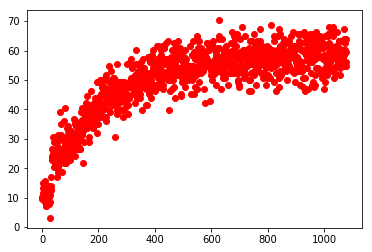

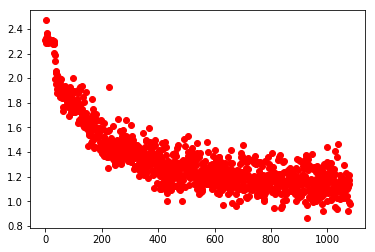

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

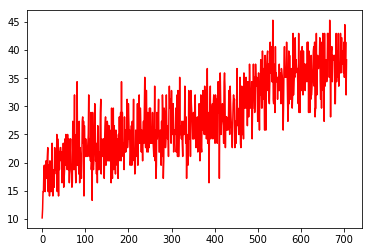

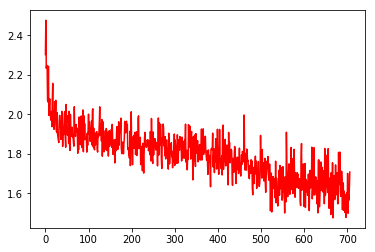

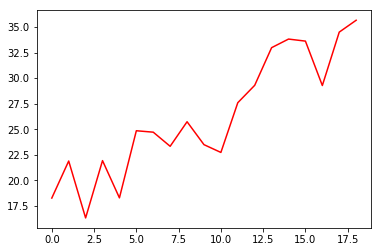

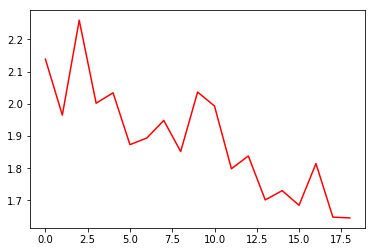

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()